In [ ]:
!nvidia-smi

In [ ]:
#!apt-get update && apt-get -qq install xxd
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==2.1.1
#!pip install tf-nightly
#!pip install tensorflow==2.1.1

In [ ]:
!apt-get -qq install xxd

In [ ]:
# !pip uninstall scipy -y
# !pip install scipy==1.7.0

In [1]:
import pandas as pd
from datetime import datetime
from ftplib import FTP
import numpy as np
import tensorflow as tf
#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
from tensorflow import keras
from tensorflow.keras import layers
import urllib.request
from matplotlib import pyplot as plt
import time
from scipy import stats
from drive.MyDrive.AnoML.AnoML import *
from drive.MyDrive.AnoML.MLModels import *
print (tf.__version__)

2.5.0


In [2]:
AnoMLTest()

AnoML verion 0.01


In [2]:
GoogleDrive = "/content/drive/MyDrive/Datasets/"
BaseFolder=GoogleDrive+"Smart_Buildings/"
NormalData = []
NormalData.append(BaseFolder+"20200724081246/20200724081246.csv")
#NormalData.append(BaseFolder+"20201123095814/20201123095814.csv")
#NormalData.append(BaseFolder+"20201221082735/20201221082735.csv")
#Assuminig the last dataset from 12-21-2020 is anomlous (will change later)
AttackData=[]
AttackData.append(BaseFolder+"20210326_20210629/ingestor_20210326-20210618.csv")
AttackData.append(BaseFolder+"20210326_20210629/ingestor_20210618-20210629.csv")
#Lableled first 165 rows of 12-21-2020 data as anomlous only for sense-hat
#Header for each type of device, it will help to get the specific device's data
HeaderFile = "headers.csv"
Headers = open(BaseFolder+HeaderFile, "r")
Headers = Headers.readlines()
# office_status_codes = {'open':1, 'closed':0}
# day_codes = {'monday':0,'tuesday':1,'wednesday':2,'thursday':3,'friday':4,'saturday':5,'sunday':6}

In [3]:
Normal_df = MultiDeviceDataExtractor(NormalData, Headers, 7)
Normal_df.keys()

dict_keys(['sense-hat', 'ble_devices', 'wifi_devices', 'infra', 'co2', 'nir', 'sound3', 'sound4', 'pir', 'all-in-1'])

In [4]:
Attack_df = MultiDeviceDataExtractor(AttackData, Headers, 7)
Attack_df.keys()

dict_keys(['sense-hat', 'ble_devices', 'wifi_devices', 'infra', 'co2', 'nir', 'sound3', 'sound4', 'pir', 'all-in-1'])

In [5]:
DeviceDPs = {}
ReverseNormalization = {}
for DeviceType, DeviceData in Normal_df.items():
  Normal_df[DeviceType], DeviceDPs[DeviceType], ReverseNormalization[DeviceType]= DataCleanerNormalizer(DeviceData, "datetime")
# DeviceDPs, ReverseNormalization

Processing Time for cleaning and normalization of dataframe of shape:  (26131, 17)  =  44.84820365905762
Processing Time for cleaning and normalization of dataframe of shape:  (26151, 12)  =  37.90926933288574
Processing Time for cleaning and normalization of dataframe of shape:  (26151, 12)  =  39.15977478027344
Processing Time for cleaning and normalization of dataframe of shape:  (26136, 14)  =  42.12045669555664
Processing Time for cleaning and normalization of dataframe of shape:  (26067, 12)  =  38.99097442626953
Processing Time for cleaning and normalization of dataframe of shape:  (26139, 13)  =  46.408653259277344
Processing Time for cleaning and normalization of dataframe of shape:  (26050, 16)  =  42.0832633972168
Processing Time for cleaning and normalization of dataframe of shape:  (26095, 12)  =  37.27149963378906
Processing Time for cleaning and normalization of dataframe of shape:  (26130, 14)  =  41.35012626647949
Processing Time for cleaning and normalization of dataf

In [6]:
# Choose Device Type
DT = "nir"
Normal_df[DT].head()

index            datetime  day  count  ...  MAC  natural  artificial  desk
0     20 2020-07-24 08:25:00    0      3  ...    0      0.0    0.968839     0
1     30 2020-07-24 08:30:00    0      4  ...    0      0.0    0.967813     0
2     40 2020-07-24 08:35:00    0      5  ...    0      0.0    0.966811     0
3     50 2020-07-24 08:40:00    0      6  ...    0      0.0    0.967702     0
4     60 2020-07-24 08:45:00    0      7  ...    0      0.0    0.966508     0

[5 rows x 13 columns]

In [7]:
DataPoints = DeviceDPs[DT][8:-1]
DataPoints = ["artificial"]
DataPoints

['artificial']

In [8]:
# In case of multiple datapoints, and multiple combinations are required
DPSS = DPSubsets(DataPoints)
DPSS

List has only 1 DataPoint, No further subsets possible


['artificial']

In [11]:
# Visualize Datapoint in the unconditional dataset
VisualizeDeviceData(Normal_df[DT], DataPoints)

In [31]:
# Get Conditional DataFrame from full dataframe
Condition = "daylight_condition"
Value = 0
#if value is from Normalized column
#Value = ReverseNormalization[DT][Condition]["open"]
#OR
#Value = ReverseNormalization[DT][Condition]["closed"]
Normal_df_cond = Normal_df[DT][Normal_df[DT][Condition]==Value].copy()
Normal_df_cond = Normal_df_cond.reset_index()
Attack_df_cond = Attack_df[DT][Attack_df[DT][Condition]==Value].copy()
Attack_df_cond = Attack_df_cond.reset_index()

In [32]:
# Visualize Datapoint in the unconditional dataset
VisualizeDeviceData(Normal_df_cond, DataPoints)
VisualizeDeviceData(Attack_df_cond, DataPoints, "Test")

In [39]:
# Normalize of reduce dataframe?
#Reduction of DataPoints and adding new column in dataframe
Reducer = "Kurtosis"
ReducedValues = DataReducer(Normal_df[DT], DataPoints, Reducer)
ReduceDFName = DT+"_"+'-'.join(DataPoints)+"_"+Reducer
if (ReducedValues):
  Normal_df[ReduceDFName] = ReducedValues
else:
  Normal_df[ReduceDFName] = Normal_df_cond[DataPoints]
#Copy datetime from origional dataframe or visualization
Normal_df[ReduceDFName]["datetime"] = Normal_df_cond["datetime"]
Normal_df[ReduceDFName].head()

Atleast two DataPoints should be provided for reduction


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



artificial            datetime
0        -0.0 2020-07-24 21:15:00
1        -0.0 2020-07-24 21:20:00
2        -0.0 2020-07-24 21:25:00
3        -0.0 2020-07-24 21:30:00
4        -0.0 2020-07-24 21:35:00

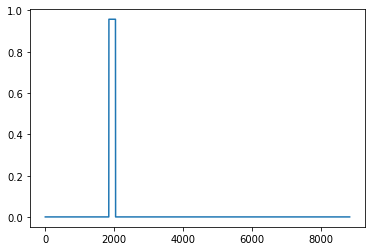

In [41]:
import matplotlib.pyplot as plt
plt.plot(Normal_df[ReduceDFName][DataPoints])
plt.show()

In [42]:
Normal_df[ReduceDFName].head()

artificial            datetime
0        -0.0 2020-07-24 21:15:00
1        -0.0 2020-07-24 21:20:00
2        -0.0 2020-07-24 21:25:00
3        -0.0 2020-07-24 21:30:00
4        -0.0 2020-07-24 21:35:00

In [ ]:
# Scale DataFrame using Standard or MinMax Scaler and add resuting DataFrame in Object
Scaler = "Standard"
Normal_df[DT+"_"+Scaler] = DataScaler(Normal_df[DT], DataPoints, Scaler)
Normal_df[DT+"_"+Scaler].head()

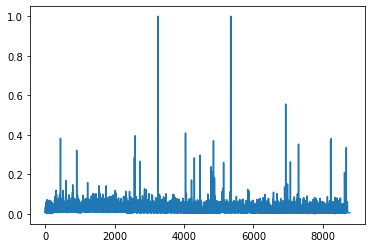

In [44]:
#Adding Model Details
# ModelDetails = {}
# ModelDetails["batch_size"] = 10
# ModelDetails["epochs"] = 100
# ModelDetails["kernel_size"] = 32
# ModelDetails["filters"] = 5
KERNELS = 32
FILTERS=5
TIME_STEPS = (KERNELS + FILTERS) * 2
# ModelDetails["TS"] = TIME_STEPS
# ModelDetails can also be added in one line:
ModelDetails = {"batch_size":0, "epochs":100, "kernel_size":KERNELS, "filters": FILTERS, "TS":TIME_STEPS}
TrainModel(ModelDetails, DF, DPs, DFName, False)
TST = time.time()
DataPoints = ["p"]
history, model = CNN1D_Model(Normal_df_cond, DataPoints, ModelDetails)
TET = time.time()
TT = TET - TST
print ("Training Time:", TT)

This function requires tensorflow version 2.1.1, please install required version and retry
Training Time: 0.0001823902130126953


In [30]:
#Convert Train and/or Test Data into Time Series
#Train Data will be converted by ML_Model
# DataPoints=["p"]
TrainX, TrainY = Convert2TimeSeries(Normal_df_cond, DataPoints, TIME_STEPS, False)
TestX, TestY = Convert2TimeSeries(Attack_df_cond, DataPoints, TIME_STEPS, False)
Normal_df_cond.shape, TrainX.shape, TrainY.shape, Attack_df_cond.shape, TestX.shape, TestY.shape

Time consumed in TS conversion 14182.401895523071 for  (8647, 1)
Time consumed in TS conversion 23937.817335128784 for  (13520, 1)


((8647, 18), (8647, 74, 1), (8647, 1), (13520, 20), (13520, 74, 1), (13520, 1))

In [31]:
TIME_STEPS, (KERNALS + FILTERS) * 2

(74, 64)

In [33]:
# print ("Train Data", TrainX.shape)
Attack_df_cond = Attack_df_cond[TIME_STEPS:]
Normal_df_cond = Normal_df_cond[TIME_STEPS:]
TrainPrediction = model.predict(TrainX)

In [34]:
Normal_df_cond.shape[0], TrainX.shape[0], TrainPrediction.shape[0], TIME_STEPS

(8573, 8647, 8647, 74)

In [35]:
Threshold_Level = 8
# print ("TrainPrediction", TrainPrediction.shape, "TrainLable", TrainY.shape)
TrainY = np.reshape(TrainY, TrainPrediction.shape, order='C')
# print ("TrainPrediction", TrainPrediction.shape, "TrainLable", TrainY.shape)
TrainMAELoss = np.mean(np.abs(TrainPrediction - TrainY), axis=1)
# print ("TrainMAELoss", TrainMAELoss.shape)
TrainThreshold = np.mean(TrainMAELoss) + (Threshold_Level*np.std(TrainMAELoss))
# print (len(TrainMAELoss), Normal_df["sound3"].shape, TIME_STEPS, Normal_df["sound3"].shape[0]-TIME_STEPS)
Normal_df_cond["Loss"]=TrainMAELoss[:-TIME_STEPS]
Normal_df_cond["Threshold"]=TrainThreshold
Normal_df_cond["Anomaly"]=Normal_df_cond["Loss"] > Normal_df_cond["Threshold"]
NormalAnomalies_Train = Normal_df_cond[Normal_df_cond["Anomaly"]==True][["datetime", "p", "Loss", "Anomaly"]]
Normal_df_cond["Anomaly"].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

False    8550
True       23
Name: Anomaly, dtype: int64

In [37]:
# print ("Train Data", TestX.shape)
TestPrediction = model.predict(TestX)
# print ("TrainPrediction", TestPrediction.shape, "TestLable", TestY.shape)
TestY = np.reshape(TestY, TestPrediction.shape, order='C')
# print ("TrainPrediction", TrainPrediction.shape, "TrainLable", TrainY.shape)
TestMAELoss = np.mean(np.abs(TestPrediction - TestY), axis=1)
# print ("TestMAELoss", TestMAELoss.shape)
TestThreshold = np.mean(TestMAELoss) + (Threshold_Level*np.std(TestMAELoss))
Attack_df_cond["Loss"]=TestMAELoss[:-TIME_STEPS]
Attack_df_cond["TrainThreshold"]=TrainThreshold
Attack_df_cond["TestThreshold"]=TestThreshold
Attack_df_cond["AnomalyTrainThreshold"]=Attack_df_cond["Loss"] > Attack_df_cond["TrainThreshold"]
Attack_df_cond["AnomalyTestThreshold"]=Attack_df_cond["Loss"] > Attack_df_cond["TestThreshold"]
AttackAnomalies_Test = Attack_df_cond[Attack_df_cond["AnomalyTestThreshold"]==True][["datetime", "p", "Loss"]]
AttackAnomalies_Train = Attack_df_cond[Attack_df_cond["AnomalyTrainThreshold"]==True][["datetime", "p"]]
Attack_df_cond["AnomalyTrainThreshold"].value_counts(), Attack_df_cond["AnomalyTestThreshold"].value_counts()

(False    13326
 True       120
 Name: AnomalyTrainThreshold, dtype: int64, False    13361
 True        85
 Name: AnomalyTestThreshold, dtype: int64)

In [38]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
# [Normal_df["sound3"]["office_condition"]==0]
fig.add_trace(go.Scatter(x=Normal_df_cond["datetime"], y=Normal_df_cond["p"], mode='lines', name="p in Train Data"))
fig.add_trace(go.Scatter(x=NormalAnomalies_Train["datetime"], y=NormalAnomalies_Train["p"], mode='markers', name="Anomalies in Training Data"))

fig.add_trace(go.Scatter(x=Attack_df_cond["datetime"], y=Attack_df_cond["p"], mode='lines', name="p"))
fig.add_trace(go.Scatter(x=AttackAnomalies_Train["datetime"], y=AttackAnomalies_Train["p"], mode='markers', name="Anomalies in Test Data using Train Threshold"))
fig.add_trace(go.Scatter(x=AttackAnomalies_Test["datetime"], y=AttackAnomalies_Test["p"], mode='markers', name="Anomalies in Test Data using Test Threshold"))
fig.update_layout(
xaxis_title="Timeline",
yaxis_title=DT+"_"+"-".join(DataPoints))
fig.show()
fig.data = []

In [18]:
print ("Report")
print ("Time Steps", TIME_STEPS)
print ("Training Data Shape, TS Train Data Shape, Test Data Shape, TS Test Data Shape")
print (Normal_df_cond.shape, TrainX.shape, Attack_df_cond.shape, TestX.shape)
print ("Training Time:", TT)
print ("Threshold calculation = mean+",Threshold_Level,"*std")
print ("Train Data")
print ("MAELoss - Mean, Max, Min, Std", np.mean(TrainMAELoss), max(TrainMAELoss), min(TrainMAELoss), np.std(TrainMAELoss))
print ("Recommended Threshold", TrainThreshold)
print ("Train Data Files:", '\n'.join(NormalData))
print (Normal_df_cond["Anomaly"].value_counts())
print ("Test Data")
print ("MAE Loss - Mean, Max, Min, Std", np.mean(TestMAELoss), max(TestMAELoss), min(TestMAELoss), np.std(TestMAELoss))
print ("Recommended Threshold", TestThreshold)
print ("Test Data Files:", '\n'.join(AttackData))
print (Attack_df_cond["AnomalyTrainThreshold"].value_counts(), Attack_df_cond["AnomalyTestThreshold"].value_counts())

Report
Time Steps 64
Training Data Shape, TS Train Data Shape, Test Data Shape, TS Test Data Shape
(8775, 18) (8775, 64, 1) (13648, 20) (13648, 64, 1)
Training Time: 25.2112877368927
Threshold calculation = mean+ 8 *std
Train Data
MAELoss - Mean, Max, Min, Std 0.014819776062474461 0.980592492967844 8.980977535266721e-07 0.027306492514552087
Recommended Threshold 0.23327171617889114
Train Data Files: /content/drive/MyDrive/Datasets/Simon_Data/20200724081246/20200724081246.csv
False    8752
True       23
Name: Anomaly, dtype: int64
Test Data
MAE Loss - Mean, Max, Min, Std 0.02739177747175908 1.039277722672224 1.8014341592771654e-06 0.0792139525244241
Recommended Threshold 0.6611033976671519
Test Data Files: /content/drive/MyDrive/Datasets/Simon_Data/ingestor_20210326_20210629/ingestor_20210326-20210618.csv
/content/drive/MyDrive/Datasets/Simon_Data/ingestor_20210326_20210629/ingestor_20210618-20210629.csv
False    13526
True       122
Name: AnomalyTrainThreshold, dtype: int64 False    13

In [ ]:
SaveTFModel(model, BaseFolder, DT, DataPoints)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/Simon_Data/sound3_p/assets


'Model Save at /content/drive/MyDrive/Datasets/Simon_Data/sound3_p'

In [ ]:
############################################################# All misc code from previous work below #############################################################

In [ ]:

# allz = AllData[i]
# allz = pd.DataFrame(allz,columns=['value'])
# X_all, y_all = ConvertInTimeSeries(allz[['value']], allz.value, TIME_STEPS)
# AllPrediction = model.predict(X_all)
# y_all = np.reshape(y_all, AllPrediction.shape, order='C')
# #print (NormalPrediction.shape, y_train.shape)
# all_mae_loss_xt = np.mean(np.abs(AllPrediction - y_all), axis=1) 
# thresholdAll = np.mean(all_mae_loss_xt) + (1*np.std(all_mae_loss_xt))
# print (ScaleTitle, threshold, thresholdAnomaly, thresholdAll)
# print (len(all_mae_loss_xt), df_main.shape)
# df_main = df_main [:len(all_mae_loss_xt)]
# df_main[ScaleTitle+"Loss"] = all_mae_loss_xt
# df_main[ScaleTitle+"Threshold"] = threshold
# df_main[ScaleTitle] = df_main[ScaleTitle+"Loss"] > df_main[ScaleTitle+"Threshold"]
# AnomalyCodes = {False:1, True:-1}
# df_main[ScaleTitle] = df_main[ScaleTitle].map(AnomalyCodes)
# df_main[ScaleTitle].value_counts()
# print (df_main.shape, allz.shape)
# CM[i]={}
# CM[i]["CM"] = confusion_matrix(df_main["Anomaly"], df_main[ScaleTitle])
# CM[i]["Title"] = ScaleTitle
# print ("Accuracy", accuracy_score(df_main["Anomaly"], df_main[ScaleTitle]))
# print (df_main["Anomaly"].value_counts(), df_main[ScaleTitle].value_counts())
# #Save TF Model in Google Drive
# MODEL_DIR = MODEL_STORE+ScaleTitle
# model.save(MODEL_DIR, save_format="tf")
# #Convert TF Model to TFLite
# converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# tflite_model = converter.convert()
# TFL_FILE = MODEL_DIR+".tfl"
# TFM_FILE = MODEL_DIR+".h"
# # Convert and Upload TFL and TFM Models
# open(TFL_FILE, "wb").write(tflite_model)
# #Convert TFLite to TFMicro
# !xxd -i {TFL_FILE} > {TFM_FILE}
# # Update variable names
# REPLACE_TEXT = TFL_FILE.replace('/', '_').replace('.', '_')
# !sed -i 's/'{REPLACE_TEXT}'/g_model/g' {TFM_FILE}
# LogActivity = MODEL_DIR+","+str(threshold)
# WriteLog(LogActivity, CONFIG_FILE)

In [ ]:
# Analysis = []
# Analysis.append([stats.kurtosis, "Kurtosis"])
# Analysis.append([stats.skew, "Skew"])
# Analysis.append([stats.median_abs_deviation, "MAD"])
# Analysis.append([np.average, "Average"])
# Analysis.append([np.std, "StDev"])
# def AnalyzeStats(Analysis, SubSet, NDF):
#     AllNorz=[]
#     for A in Analysis:
#         norz = []
#         for ns in NDF[SubSet].to_numpy():
#             norz.append(A[0](ns))
#         AllNorz.append(norz)
#     return AllNorz

In [ ]:
# DB_DRIVE_LOCATION = "/content/drive/MyDrive/Datasets/AnoMLDatasetLabeled/"
# DATASET_NAME = "AnoMLDatasetLabeled"
# MODEL_STORE = DB_DRIVE_LOCATION+DATASET_NAME+"/"
# CONFIG_FILE = MODEL_STORE+"Edge-Fog-Cloud_Analysis.csv"
# DB_FILENAME = DB_DRIVE_LOCATION+DATASET_NAME+".csv"
# KERNALS = 28
# FILTERS = 4
# NEURONS = 64
# BATCH_SIZE = 4
# LEARNING_RATE = 0.002
# EPOCHS = 20
# TIME_STEPS = (KERNALS + FILTERS) * 2
# #TIME_STEPS = 16
# SM = "SS"
# ALGO = "Conv1D"
# Log={}
# def ConvertInTimeSeries(S, V, steps=1):
#     Series, Value = [], []
#     for i in range(len(S) - steps):
#         val = S.iloc[i:(i + steps)].values
#         Series.append(val)        
#         Value.append(V.iloc[i + steps])
#     return np.array(Series), np.array(Value)
#     #Current Model
# def MyModel(TrainData, TrainDataY, ProcessFilters, KernalSize, OutputFilters, BatchSize, Epochs, LearningRate):
#   model = keras.Sequential()
#   model.add(layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=(TIME_STEPS, 1)))
#   model.add(layers.GlobalMaxPool1D())
#   model.add(layers.Dense(units=1, activation='linear'))
#   model.compile(optimizer='adam', loss='mean_squared_error')
#   history= model.fit(TrainData, TrainDataY, batch_size=100, epochs=20)
#   return history, model
# df_main=pd.read_csv(DB_FILENAME)
# Readings = df_main.columns
# Readings = Readings[1:3]
# Normal_df = df_main.loc[df_main["Anomaly"] == 1]
# Attack_df = df_main.loc[df_main["Anomaly"] == -1]
# for R in Readings:
#     df_main[R] = pd.to_numeric(df_main[R])
# # print (df_main.head())
# AllNorz = AnalyzeStats(Analysis, Readings, Normal_df)
# AllAnoz = AnalyzeStats(Analysis, Readings, Attack_df)
# AllData = AnalyzeStats(Analysis, Readings, df_main)
# df_main.shape, Normal_df.shape,Readings, Attack_df.shape

In [ ]:
# df_main.plot()

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_main["Time"], y=df_main['Temperature'], mode='lines', name="temp"))
# fig.add_trace(go.Scatter(x=df_main["Time"], y=df_main['Humidity'], mode='lines', name="hum"))
# fig.update_layout(
# xaxis_title="DateTime",
# yaxis_title="AllData")
# fig.show()
# fig.data = []

In [ ]:
# import plotly.express as px
# import plotly.graph_objects as go
# for i in range(len(Analysis)):
#   ScaleTitle = Analysis[i][1]
#   norz = AllNorz[i]
#   anoz = AllAnoz[i]
#   norz = pd.DataFrame(norz,columns=['value'])
#   anoz = pd.DataFrame(anoz,columns=['value'])
#   fig = go.Figure()
#   fig.add_trace(go.Scatter(x=df_main["Time"], y=df_main['Temperature'], mode='lines', name="temp"))
#   fig.add_trace(go.Scatter(x=df_main["Time"], y=df_main['Humidity'], mode='lines', name="hum"))
#   fig.add_trace(go.Scatter(x=Normal_df["Time"], y=norz['value'], mode='markers', name="Normal "+Analysis[i][1]))
#   fig.add_trace(go.Scatter(x=Attack_df["Time"], y=anoz['value'], mode='markers', name="Anomaly "+Analysis[i][1]))
#   fig.update_layout(
#   xaxis_title="DateTime",
#   yaxis_title=Analysis[i][1])
#   fig.show()
#   fig.data = []

In [ ]:
# from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
# KERNALS = 36
# FILTERS = 4
# NEURONS = 64
# BATCH_SIZE = 1
# LEARNING_RATE = 0.002
# EPOCHS = 20
# CM = {}
# TIME_STEPS = (KERNALS + FILTERS) * 2
# for i in range(len(Analysis)):
#   ScaleTitle = Analysis[i][1]
#   norz = AllNorz[i]
#   norz = pd.DataFrame(norz,columns=['value'])
#   X_train, y_train = ConvertInTimeSeries(norz[['value']], norz.value, TIME_STEPS)
#   training_start_time = time.time()
#   history, model = MyModel(X_train, y_train, NEURONS, KERNALS, FILTERS, BATCH_SIZE, EPOCHS, LEARNING_RATE)
#   training_end_time = time.time()
#   training_time = training_end_time - training_start_time
#   NormalPrediction = model.predict(X_train)
#   #print (NormalPrediction)
#   y_train = np.reshape(y_train, NormalPrediction.shape, order='C')
#   #print (NormalPrediction.shape, y_train.shape)
#   train_mae_loss_xt = np.mean(np.abs(NormalPrediction - y_train), axis=1)
#   threshold = np.mean(train_mae_loss_xt)# + (3*np.std(train_mae_loss_xt))
#   #print (ScaleTitle, training_time, threshold)
#   X_test, y_test = ConvertInTimeSeries(anoz[['value']], anoz.value, TIME_STEPS)
#   AnomalyPrediction = model.predict(X_test)
#   y_test = np.reshape(y_test, AnomalyPrediction.shape, order='C')
#   #print (NormalPrediction.shape, y_train.shape)
#   test_mae_loss_xt = np.mean(np.abs(AnomalyPrediction - y_test), axis=1) 
#   thresholdAnomaly = np.mean(test_mae_loss_xt) + (3*np.std(test_mae_loss_xt))
#   #print (ScaleTitle, threshold, thresholdAnomaly)
#   allz = AllData[i]
#   allz = pd.DataFrame(allz,columns=['value'])
#   X_all, y_all = ConvertInTimeSeries(allz[['value']], allz.value, TIME_STEPS)
#   AllPrediction = model.predict(X_all)
#   y_all = np.reshape(y_all, AllPrediction.shape, order='C')
#   #print (NormalPrediction.shape, y_train.shape)
#   all_mae_loss_xt = np.mean(np.abs(AllPrediction - y_all), axis=1) 
#   thresholdAll = np.mean(all_mae_loss_xt) + (1*np.std(all_mae_loss_xt))
#   print (ScaleTitle, threshold, thresholdAnomaly, thresholdAll)
#   print (len(all_mae_loss_xt), df_main.shape)
#   df_main = df_main [:len(all_mae_loss_xt)]
#   df_main[ScaleTitle+"Loss"] = all_mae_loss_xt
#   df_main[ScaleTitle+"Threshold"] = threshold
#   df_main[ScaleTitle] = df_main[ScaleTitle+"Loss"] > df_main[ScaleTitle+"Threshold"]
#   AnomalyCodes = {False:1, True:-1}
#   df_main[ScaleTitle] = df_main[ScaleTitle].map(AnomalyCodes)
#   df_main[ScaleTitle].value_counts()
#   print (df_main.shape, allz.shape)
#   CM[i]={}
#   CM[i]["CM"] = confusion_matrix(df_main["Anomaly"], df_main[ScaleTitle])
#   CM[i]["Title"] = ScaleTitle
#   print ("Accuracy", accuracy_score(df_main["Anomaly"], df_main[ScaleTitle]))
#   print (df_main["Anomaly"].value_counts(), df_main[ScaleTitle].value_counts())
#   #Save TF Model in Google Drive
#   MODEL_DIR = MODEL_STORE+ScaleTitle
#   model.save(MODEL_DIR, save_format="tf")
#   #Convert TF Model to TFLite
#   converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
#   tflite_model = converter.convert()
#   TFL_FILE = MODEL_DIR+".tfl"
#   TFM_FILE = MODEL_DIR+".h"
#   # Convert and Upload TFL and TFM Models
#   open(TFL_FILE, "wb").write(tflite_model)
#   #Convert TFLite to TFMicro
#   !xxd -i {TFL_FILE} > {TFM_FILE}
#   # Update variable names
#   REPLACE_TEXT = TFL_FILE.replace('/', '_').replace('.', '_')
#   !sed -i 's/'{REPLACE_TEXT}'/g_model/g' {TFM_FILE}
#   LogActivity = MODEL_DIR+","+str(threshold)
#   WriteLog(LogActivity, CONFIG_FILE)

In [ ]:
# df_main.head()

In [ ]:
# df_main.to_csv(DB_DRIVE_LOCATION+"AnoML_All_Analysis.csv",index=None)

In [ ]:
# print (Analysis[0][1])
# PlotConfusionMatrix(CM[0]["CM"], CM[0]["Title"])

In [ ]:
# print (Analysis[1][1])
# PlotConfusionMatrix(CM[1]["CM"], CM[1]["Title"])

In [ ]:
# print (Analysis[2][1])
# # PlotConfusionMatrix(CM[2]["CM"], CM[2]["Title"])

In [ ]:
# print (Analysis[3][1])
# PlotConfusionMatrix(CM[3]["CM"], CM[3]["Title"])

In [ ]:
# print (Analysis[4][1])
# PlotConfusionMatrix(CM[4]["CM"], CM[4]["Title"])

In [ ]:
# df_main.head(200)

In [ ]:
# # df_main['datetime'] = pd.to_datetime(df_main['datetime'],unit='s')
# # SensorTypes = df_main.sensortype.unique()
# # ftp = FTP('ftp.ans-itsolutions.com')
# # ftp.login('mlworkflow', 'Cardiff_1884')
# # df = df_main[df_main['sensortype'] == "TH"]
# df = df_main
# train_size = int(len(df) * 1)
# test_size = len(df) - train_size
# train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
# X_train, y_train = ConvertInTimeSeries(train[['value']], train.value, TIME_STEPS)
# # X_test, y_test = ConvertInTimeSeries(test[['value']], test.value, TIME_STEPS)
# #Visualize Loss
# training_start_time = time.time()
# #history, model = MyModel(X_train, y_train, NEURONS, KERNALS, FILTERS, BATCH_SIZE, EPOCHS, LEARNING_RATE)
# #model.fit(X_train, y_train, batch_size=1, epochs=20)
# history, model = MyModel(X_train, y_train, NEURONS, KERNALS, FILTERS, BATCH_SIZE, EPOCHS, LEARNING_RATE)
# training_end_time = time.time()
# training_time = training_end_time - training_start_time

In [ ]:
# plt.plot(history.history["loss"], label="Training Loss")
# plt.legend()
# plt.show()

In [ ]:
# l=18
# h=19
# x_attack = np.random.random([TIME_STEPS]) + np.random.randint(low=l, high=h, size=TIME_STEPS)
# #x_attack = np.random.random([TIME_STEPS]) + 25
# SampleValue = np.reshape(x_attack, [1,TIME_STEPS,1], order='C')
# run_model = tf.function(lambda x: model(x))
# MODEL_DIR = ALGO+"_"+str(TIME_STEPS)
# model.save(MODEL_DIR, save_format="tf")
# #Convert TF Model to TFLite
# converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# tflite_model = converter.convert()
# # Run the model with TensorFlow Lite (to Confirm)
# SampleValue = SampleValue.astype('float32')
# interpreter = tf.lite.Interpreter(model_content=tflite_model)
# interpreter.allocate_tensors()
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# # print (output_details)
# expected = model.predict(SampleValue)
# # print ("TF Result", expected)
# interpreter.set_tensor(input_details[0]["index"], SampleValue)
# interpreter.invoke()
# result = interpreter.get_tensor(output_details[0]["index"])
# # print ("Sample for test",SampleValue)
# # print ("TF Micro Result", result)
# interpreter.reset_all_variables()
# #Visualize Results
# #Plot for SampleValue TF
# train_mae_loss = np.mean(np.abs(expected - SampleValue), axis=1)
# # plt.hist(train_mae_loss, bins=50)
# # plt.xlabel("Train MAE loss")
# # plt.ylabel("No of samples")
# # plt.show()
# print ("Range", l, h)
# threshold = np.mean(train_mae_loss)
# print("Reconstruction error threshold TFModel using sample data: ", threshold)
# #Plot for SampleValue TFL
# train_mae_loss_tfl = np.mean(np.abs(result - SampleValue), axis=1)
# # plt.hist(train_mae_loss_tfl, bins=50)
# # plt.xlabel("Train MAE loss TFLite")
# # plt.ylabel("No of samples")
# # plt.show()
# threshold_tfl = np.mean(train_mae_loss_tfl)
# print("Reconstruction error threshold with TFLite using sample data: ", threshold_tfl)
# # Get reconstruction loss threshold.
# xtPred = model.predict(X_train)

# y_train = np.reshape(y_train, xtPred.shape, order='C')
# print (xtPred.shape, y_train.shape)
# train_mae_loss_xt = np.mean(np.abs(xtPred - y_train), axis=1)
# # plt.hist(train_mae_loss_xt, bins=50)
# # plt.xlabel("Train MAE loss")
# # plt.ylabel("No of samples")
# # plt.show()
# threshold_xt = np.max(train_mae_loss_xt)
# print("Reconstruction error threshold TensorFlow using training data: ", threshold_xt)
# print ("Training Time: ", training_time)
# Log[1] = {
#     "DB_DRIVE_LOCATION": "/content/drive/MyDrive/",
#     "DATASET_NAME": "pycomm-data-2",
#     "KERNALS" : KERNALS,
#     "FILTERS" : FILTERS,
#     "NEURONS" : NEURONS,
#     "BATCH_SIZE" : BATCH_SIZE,
#     "LEARNING_RATE" : LEARNING_RATE,
#     "EPOCHS" : EPOCHS,
#     "TIME_STEPS":TIME_STEPS,
#     "SM" : SM,
#     "ALGO" : ALGO,
#     "threshold" : threshold,
#     "threshold_tfl" : threshold_tfl,
#     "threshold_xt" : threshold_xt,
#     "training_time":training_time
# }

In [ ]:
# ftp = FTP('ftp.ans-itsolutions.com')
# ftp.login('mlworkflow', 'Cardiff_1884')
# now = datetime.now()
# TFL_FILE = str(now.strftime("%m-%d-%Y-%H-%M-%S")) +"_SS_TH_"+ALGO+"_"+str(TIME_STEPS)+"_"+DATASET_NAME+".tflite"
# TFM_FILE = str(now.strftime("%m-%d-%Y-%H-%M-%S")) +"_SS_TH_"+ALGO+"_"+str(TIME_STEPS)+"_"+DATASET_NAME+".h"
# # Convert and Upload TFL and TFM Models
# open(TFL_FILE, "wb").write(tflite_model)
# #Convert TFLite to TFMicro
# !xxd -i {TFL_FILE} > {TFM_FILE}
# # Update variable names
# REPLACE_TEXT = TFL_FILE.replace('/', '_').replace('.', '_')
# !sed -i 's/'{REPLACE_TEXT}'/g_model/g' {TFM_FILE}
# #Upload TFLite File
# TFLite_File = open(TFL_FILE, "rb")
# ftp.storbinary("STOR "+TFL_FILE, TFLite_File)
# TFLite_File.close()
# #Upload TFMirco File
# TFMicro_File = open(TFM_FILE, "rb")
# ftp.storbinary("STOR "+TFM_FILE, TFMicro_File)
# TFMicro_File.close()

In [ ]:
# Log = {}
# Log[1] = {
#     "DB_DRIVE_LOCATION": "/content/drive/MyDrive/",
#     "DATASET_NAME": "pycomm-data-2",
#     "KERNALS" : KERNALS,
#     "FILTERS" : FILTERS,
#     "NEURONS" : NEURONS,
#     "BATCH_SIZE" : BATCH_SIZE,
#     "LEARNING_RATE" : LEARNING_RATE,
#     "EPOCHS" : EPOCHS,
#     "TIME_STEPS":TIME_STEPS,
#     "SM" : SM,
#     "ALGO" : ALGO,
#     "threshold" : threshold,
#     "threshold_tfl" : threshold_tfl,
#     "threshold_xt" : threshold_xt,
#     "training_time":training_time
# }
# #print (Log)
# print (SampleValue)
# print (SampleValue.shape)
# a = np.array([[1,2,3],[4,5,6]])
# print (a.shape)

In [ ]:
'''


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import seaborn as sns
import urllib.request
DB_FILE_URL = "http://safehome.technology/iot/data/databank.csv"
DB_FILENAME = "/content/databank.csv"
DATASET_NAME = "DataBank"
SM = "SS"
TIME_STEPS = 50
TFL_FILE = "LSTM-Loop-SS-Pycomm-2.tflite"

SyntaxError: ignored

In [ ]:
# #Hakan Temperature and Humidity Dataset
# #Open CSV File
# urllib.request.urlretrieve(DB_FILE_URL, DB_FILENAME)
# #Copy CSV File into dataframe
# #skiprows=1 if header is on the top of file
# #usecols, names is to redefine column names
# #0-1613085549,1-01,2-1,3-005,4-W,5-HU,6-41,0,0.005323,1
# df=pd.read_csv(DB_FILENAME, header=None, usecols=[5,6], names=["sensortype","value"])
# #Convert datetime string into Datatime format; format='%Y-%m-%d %H:%M:%S' or any other format exists in the file
# #visualize data
# df = df[df['sensortype'] == "TH"]
# df.plot(y=["value"], figsize=(50,10))
# plt.plot()
# #df.head()

In [ ]:
#See data in rows
#df.head()

In [ ]:
#

In [ ]:
# #Split Train/Test subsets
# train_size = int(len(df) * 0.80)
# test_size = len(df) - train_size
# train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

In [ ]:
# #This Function will convert one-dimentional series into time-series data
# def ConvertInTimeSeries(S, V, steps=1):
#     Series, Value = [], []
#     for i in range(len(S) - steps):
#         val = S.iloc[i:(i + steps)].values
#         Series.append(val)        
#         Value.append(V.iloc[i + steps])
#         #print ("Xs = ")
#         #print (v)
#         #print ("Ys = ")
#         #print (y.iloc[i + time_steps])
#     return np.array(Series), np.array(Value)
# # reshape to [samples, time_steps, n_features] by the given function
# X_train, y_train = ConvertInTimeSeries(train[['value']], train.value, TIME_STEPS)
# X_test, y_test = ConvertInTimeSeries(test[['value']], test.value, TIME_STEPS)
# #print (X_train[1])
# #print (y_train[1])

In [ ]:
#Create Model
model = tf.keras.Sequential()
# model.add(
    tf.keras.Input(
    shape=(X_train.shape[1],X_train.shape[2])
    )
)
model.add(
    tf.keras.layers.LSTM(32, return_sequences=True, activation='relu')
)
model.add(
    tf.keras.layers.LSTM(32, activation='relu')
)
model.add(
    tf.keras.layers.Dense(X_train.shape[1])
)

print (model.summary())
model.compile (
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002)
    )
model.fit(X_train, y_train, batch_size=32, epochs=20)
'''
LSTM_Model = Sequential([
                         Input(shape=(X_train.shape[1], X_train.shape[2]), name='input'),
                         LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
                         Dropout(rate=0.2),
                         RepeatVector(n=X_train.shape[1]),
                         LSTM(units=64, return_sequences=True),
                         Dropout(rate=0.2),
                         TimeDistributed(Dense(units=X_train.shape[2])),
                         Dense(units=X_train.shape[2], name='output')
])
'''
#LSTM_Model.add(LSTM(units=256, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
#Add Layers
'''
LSTM_Model.add()
LSTM_Model.add()
LSTM_Model.add()
LSTM_Model.add()
LSTM_Model.add()
LSTM_Model.add()
LSTM_Model.add()
LSTM_Model.add()
'''
#Model Compile Settings
#LSTM_Model.compile(loss='mae', optimizer='adam')
#Show Model Summary
#LSTM_Model.summary()

In [ ]:
# eval_result = model.evaluate(X_test, y_test, batch_size=64, verbose=2)
# eval_result

In [ ]:
# l=24.3
# h=25
# x_attack = np.random.random([TIME_STEPS]) + np.random.randint(low=l, high=h, size=TIME_STEPS)
# SampleValue = np.reshape(x_attack, [1,TIME_STEPS,1], order='C')
# print (SampleValue)
# predicted_values = model.predict(SampleValue)
# print (predicted_values)
# difference = np.abs(predicted_values - SampleValue)
# print (difference)
# difference =  np.mean(difference, axis=1)
# print(difference.mean())
# if (difference.mean() - eval_result) > .5:
#   print ("Anomaly")
# else:
#   print ("Normal")


In [ ]:
# run_model = tf.function(lambda x: model(x))
# # This is important, let's fix the input size.
# BATCH_SIZE = 1
# STEPS = 200
# INPUT_SIZE = 200

# # model directory.
# MODEL_DIR = "keras_lstm"
# model.save(MODEL_DIR, save_format="tf")

# converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# tflite_model = converter.convert()

In [ ]:
# # Run the model with TensorFlow to get expected results.
# X_test = X_test.astype('float32')
# SampleValue = SampleValue.astype('float32')
# # Run the model with TensorFlow Lite
# interpreter = tf.lite.Interpreter(model_content=tflite_model)
# interpreter.allocate_tensors()
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# expected = model.predict(X_test[0:1])
# interpreter.set_tensor(input_details[0]["index"], SampleValue[0:1, :, :])
# interpreter.invoke()
# result = interpreter.get_tensor(output_details[0]["index"])
# # Assert if the result of TFLite model is consistent with the TF model.
# #np.testing.assert_almost_equal(expected, result)
# #print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")
# # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
# # the states.
# # Clean up internal states.
# interpreter.reset_all_variables()
# difference =  np.mean(np.abs(result - SampleValue), axis=1)
# print(difference.mean())
# if (difference.mean() - eval_result) > .5:
#   print ("Anomaly")
# else:
#   print ("Normal")

In [ ]:
# open(TFL_FILE, "wb").write(tflite_model)
# LSTM_03-23-2021-11-30-08_Pycomm2
# TFLite_File = open(TFL_FILE, "rb")
# from ftplib import FTP
# from datetime import datetime
# now = datetime.now()
# ftp = FTP('ftp.ans-itsolutions.com')
# ftp.login('mlworkflow', 'Cardiff_1884')
# FileName = now.strftime("%m-%d-%Y-%H-%M-%S") +"_"+str(TIME_STEPS)+"_"+ TFL_FILE
# print (FileName)
# print (ftp.storbinary("STOR "+FileName, TFLite_File))
# TFLite_File.close()
# ftp.quit()

In [ ]:
# sense_hat_history = LSTM_Model.fit(
#     X_train, y_train,
#     epochs=15,
#     batch_size=64,
#     validation_split=0.2,
#     shuffle=False
# )
# #sense_hat_history=LSTM_Model.fit(X_train, y_train, epochs=10, batch_size=1, shuffle=False)

In [ ]:
# LSTM_Model.evaluate(
#     X_test, y_test,
#     verbose=0)

In [ ]:
# SampleValue = X_test[1:2]
# #SampleValue = np.array([[[40,40,40,11,22]]])
# #print (X_test.shape)
# #print (SampleValue.shape)
# #print (SampleValue)
# PredictedValue = LSTM_Model.predict(SampleValue)
# Anomaly = PredictedValue - 1.2
# print (PredictedValue)

In [ ]:
# import tensorflow.compat.v2 as tfc
# tfc.enable_v2_behavior()
# run_model = tfc.function(lambda x: LSTM_Model(x))
# # This is important, let's fix the input size.
# BATCH_SIZE = 1
# STEPS = 200
# INPUT_SIZE = 200

# # model directory.
# MODEL_DIR = "/content/keras_lstm/"
# LSTM_Model.save(MODEL_DIR, save_format="tf")

# converter = tfc.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# tflite_model = converter.convert()

In [ ]:
# # Run the model with TensorFlow to get expected results.
# TEST_CASES = 10

# # Run the model with TensorFlow Lite
# interpreter = tfc.lite.Interpreter(model_content=tflite_model)
# interpreter.allocate_tensors()
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# print (input_details)
# for i in range(TEST_CASES):
#   expected = LSTM_Model.predict(X_test[i:i+1])
#   interpreter.set_tensor(input_details[0]["index"], y_test[1])
#   interpreter.invoke()
#   result = interpreter.get_tensor(output_details[0]["index"])

#   # Assert if the result of TFLite model is consistent with the TF model.
#   np.testing.assert_almost_equal(expected, result)
#   print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

#   # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
#   # the states.
#   # Clean up internal states.
#   interpreter.reset_all_variables()

In [ ]:
# plt.plot(sense_hat_history.history['loss'], label='loss')
# plt.plot(sense_hat_history.history['val_loss'], label='val_loss')
# plt.legend();
# sense_hat_history

In [ ]:
# X_test_pred = LSTM_Model.predict(X_test)
# test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [ ]:
# sns.distplot(test_mae_loss, bins=50, kde=True);

In [ ]:
# THRESHOLD = .95
# test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
# test_score_df['loss'] = test_mae_loss
# test_score_df['threshold'] = THRESHOLD
# test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
# test_score_df['value'] = test[TIME_STEPS:].value
# plt.plot(test_score_df.index, test_score_df.loss, label='loss')
# plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
# plt.xticks(rotation=25)
# plt.legend();
# test_score_df.head()
# print (len(test_score_df[test_score_df['anomaly']==True]))
# print (len(test_score_df[test_score_df['anomaly']==False]))

In [ ]:
#

In [ ]:
# anomalies = test_score_df[test_score_df.anomaly == True]
# plt.figure(figsize=(40,20))
# plt.plot(
#   test[TIME_STEPS:].index, 
#   test[TIME_STEPS:].value, 
#   label='Testing values'
# );

# plt.plot(
#   train[TIME_STEPS:].index, 
#   train[TIME_STEPS:].value, 
#   label='Training values'
# );
# plt.xticks(rotation=25)
# plt.legend();
# sns.scatterplot(
#   anomalies.index,
#   anomalies.value,
#   color=sns.color_palette()[3],
#   s=52,
#   label='anomaly'
# )

In [ ]:
# X_train_pred = LSTM_Model.predict(X_train)
# train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [ ]:
# sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
# THRESHOLD = 2.4
# train_score_df = pd.DataFrame(index=train[TIME_STEPS:].index)
# train_score_df['loss'] = train_mae_loss
# train_score_df['threshold'] = THRESHOLD
# train_score_df['anomaly'] = train_score_df.loss > train_score_df.threshold
# train_score_df['value'] = train[TIME_STEPS:].value
# plt.plot(train_score_df.index, train_score_df.loss, label='loss')
# plt.plot(train_score_df.index, train_score_df.threshold, label='threshold')
# plt.xticks(rotation=25)
# plt.legend();
# print (len(train_score_df[train_score_df['anomaly']==True]))
# print (len(train_score_df[train_score_df['anomaly']==False]))
# train_score_df

In [ ]:
# train_anomalies = train_score_df[train_score_df.anomaly == True]
# plt.figure(figsize=(40,20))
# plt.plot(
#   test[TIME_STEPS:].index, 
#   test[TIME_STEPS:].value, 
#   label='Testing values'
# );

# plt.plot(
#   train[TIME_STEPS:].index, 
#   train[TIME_STEPS:].value, 
#   label='Training values'
# );
# plt.xticks(rotation=25)
# plt.legend();
# sns.scatterplot(
#   train_anomalies.index,
#   train_anomalies.value,
#   color=sns.color_palette()[3],
#   s=52,
#   label='anomaly'
# )

In [ ]:
np.mean(np.abs(X_test_pred - X_test),axis=1)

In [ ]:
# #conver model in TFLite
# run_model = tf.function(lambda x: LSTM_Model(x))
# # This is important, let's fix the input size.
# BATCH_SIZE = 1
# STEPS = 100
# INPUT_SIZE = TIME_STEPS
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec([None, None, 1], LSTM_Model.inputs[0].dtype))

# # model directory.
# MODEL_DIR = "/content/keras_lstm/"
# LSTM_Model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

# converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# tflite_model = converter.convert()

In [ ]:
# # Run the model with TensorFlow to get expected results.
# TEST_CASES = 10

# # Run the model with TensorFlow Lite
# interpreter = tf.lite.Interpreter(model_content=tflite_model)
# interpreter.allocate_tensors()
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# for i in range(TEST_CASES):
#   expected = LSTM_Model.predict(X_test[i:i+1])
#   interpreter.set_tensor(input_details[0]["index"], X_test[i:i+1, :, :])
#   interpreter.invoke()
#   result = interpreter.get_tensor(output_details[0]["index"])

#   # Assert if the result of TFLite model is consistent with the TF model.
#   np.testing.assert_almost_equal(expected, result)
#   print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

#   # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
#   # the states.
#   # Clean up internal states.
#   interpreter.reset_all_variables()